# Imports

In [1]:
import pandas as pd

from preparer import dataset_stats, groups_size_hist

# Datasets stats

In [2]:
datasets_dict = {
    'eth': dataset_stats('./ETH/seq_eth'),
    'hotel': dataset_stats('./ETH/seq_hotel'),
    'zara01': dataset_stats('./UCY/zara01'),
    'zara02': dataset_stats('./UCY/zara02'),
    'students03': dataset_stats('./UCY/students03')
}

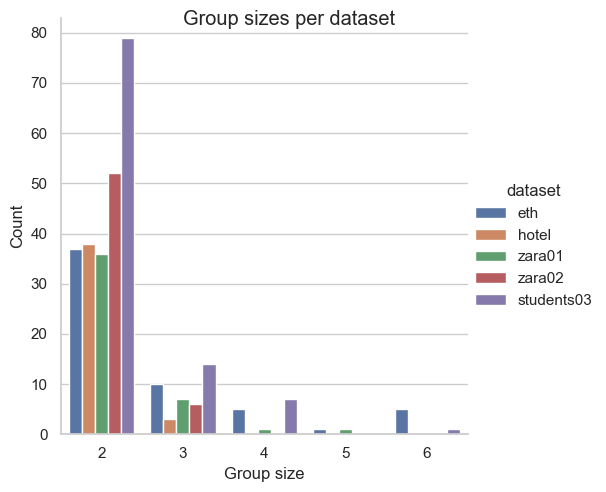

In [3]:
groups_dict = {
    'eth': datasets_dict['eth']['groups'],
    'hotel': datasets_dict['hotel']['groups'],
    'zara01': datasets_dict['zara01']['groups'],
    'zara02': datasets_dict['zara02']['groups'],
    'students03': datasets_dict['students03']['groups']
}
groups_size_hist(groups_dict, './group_size_plot.png')

In [4]:
stats_df = pd.DataFrame.from_dict(datasets_dict, orient='index')
stats_df['groups'] = stats_df['groups'].str.len()
stats_df.drop(columns=['df'])

,groups,agents,frames,single agent groups,duration
eth,58,360,1448,201,773.4
hotel,41,390,1168,305,722.4
zara01,45,148,866,46,360.4
zara02,58,204,1052,82,420.4
students03,101,428,540,194,215.6


# Single dataset preprocessing

In [5]:
dataset = 'eth'
df = datasets_dict[dataset]['df']
groups = datasets_dict[dataset]['groups']

In [6]:
df.head()

,frame_id,agent_id,pos_x,pos_y,v_x,v_y,timestamp
0,780,1,8.456844,3.588066,1.671714,0.176292,52.0
1,786,1,9.125530,3.658583,1.662877,0.326723,52.4
2,792,1,9.787146,3.849445,1.683334,0.371084,52.8
3,798,1,10.472197,3.955450,1.598568,0.264795,53.2
4,804,1,11.066000,4.061280,1.574526,0.456390,53.6


number of frames for each agent

In [7]:
agent_occurrences = df['agent_id'].value_counts()
agent_occurrences

171    190
216    101
238     95
52      64
51      64
      ... 
26       3
288      3
282      2
115      2
292      2
Name: agent_id, Length: 360, dtype: int64

number of people for each frame

In [8]:
frame_occurrences = df['frame_id'].value_counts()
frame_occurrences

10383    27
10437    26
10377    26
10365    26
10371    26
         ..
4625      1
8703      1
8679      1
4577      1
1950      1
Name: frame_id, Length: 1448, dtype: int64

In [9]:
from preparer import remove_agents_and_frames_with_insufficient_data
df = remove_agents_and_frames_with_insufficient_data(dataframe=df, frames_threshold=5, agents_threshold=7)
df.head()

,frame_id,agent_id,pos_x,pos_y,v_x,v_y,timestamp
104,948,5,8.612637,4.203888,1.617353,0.061244,63.2
105,948,4,8.899052,4.973553,1.504100,0.148273,63.2
106,948,3,4.459227,6.987026,-0.578897,0.035336,63.2
107,948,2,3.576947,7.818493,-0.817952,0.165903,63.2
108,948,6,3.416835,6.179619,-1.012847,-0.003662,63.2


In [10]:
agent_occurrences = df['agent_id'].value_counts()
agent_occurrences

171    80
238    69
216    43
358    41
357    41
       ..
98      5
96      5
224     5
58      5
222     5
Name: agent_id, Length: 289, dtype: int64

In [11]:
frame_occurrences = df['frame_id'].value_counts()
frame_occurrences

10383    27
10371    26
10365    26
10377    26
10437    26
         ..
4727      7
8601      7
8589      7
8577      7
3120      7
Name: frame_id, Length: 536, dtype: int64

# Trajectories

Use of eth proposed loader

In [12]:
from loader import load_eth
eth_traj_dataset = load_eth('./ETH/seq_eth/obsmat.txt')
eth_trajs = eth_traj_dataset.get_trajectories()
print(eth_traj_dataset.data.iloc[eth_trajs.groups[0, 1]])  # get trajectory of scene_id 0 and pedestrian_id 1
print(eth_traj_dataset.data[eth_traj_dataset.data['agent_id'] == 1])
print(eth_traj_dataset.data.shape)

   frame_id  agent_id      pos_x     pos_y     vel_x     vel_y  scene_id  \
0       780         1   8.456844  3.588066  1.671714  0.176292         0   
1       786         1   9.125530  3.658583  1.662877  0.326723         0   
2       792         1   9.787146  3.849445  1.683334  0.371084         0   
3       798         1  10.472197  3.955450  1.598568  0.264795         0   
4       804         1  11.066000  4.061280  1.574526  0.456390         0   
6       810         1  11.731818  4.320563  1.644127  0.544391         0   
8       816         1  12.381302  4.496793  1.623709  0.440576         0   

        label  timestamp  
0  pedestrian       52.0  
1  pedestrian       52.4  
2  pedestrian       52.8  
3  pedestrian       53.2  
4  pedestrian       53.6  
6  pedestrian       54.0  
8  pedestrian       54.4  
   frame_id  agent_id      pos_x     pos_y     vel_x     vel_y  scene_id  \
0       780         1   8.456844  3.588066  1.671714  0.176292         0   
1       786         1  

# Thoughts and TODOs

goal: data for all agents, both in or not in groups
problems: agents in low number of frames

number of same agents in X consecutive frames

In [13]:
agent_sets = df.groupby('frame_id')['agent_id'].apply(list).reset_index(name='agents')
agent_sets.head()

,frame_id,agents
0,948,"[5, 4, 3, 2, 6, 7, 8]"
1,954,"[5, 4, 3, 2, 6, 7, 8]"
2,960,"[5, 4, 3, 2, 6, 7, 8]"
3,966,"[5, 4, 3, 2, 6, 7, 8]"
4,972,"[5, 4, 3, 2, 6, 7, 8]"


In [14]:
frame_ids = agent_sets.frame_id.values
consecutive_frames = 3 # change this for longer trajectory
frame_id_combs = [list(frame_ids[i:i+consecutive_frames]) for i, frame_id in enumerate(frame_ids[:-consecutive_frames])]
frame_id_combs

[[948, 954, 960],
 [954, 960, 966],
 [960, 966, 972],
 [966, 972, 978],
 [972, 978, 984],
 [978, 984, 1074],
 [984, 1074, 1080],
 [1074, 1080, 1086],
 [1080, 1086, 1092],
 [1086, 1092, 1098],
 [1092, 1098, 1104],
 [1098, 1104, 1110],
 [1104, 1110, 1116],
 [1110, 1116, 1122],
 [1116, 1122, 1128],
 [1122, 1128, 1134],
 [1128, 1134, 1140],
 [1134, 1140, 1146],
 [1140, 1146, 1152],
 [1146, 1152, 1158],
 [1152, 1158, 1164],
 [1158, 1164, 1170],
 [1164, 1170, 1176],
 [1170, 1176, 1182],
 [1176, 1182, 1188],
 [1182, 1188, 1194],
 [1188, 1194, 1200],
 [1194, 1200, 1206],
 [1200, 1206, 1212],
 [1206, 1212, 1218],
 [1212, 1218, 1224],
 [1218, 1224, 1230],
 [1224, 1230, 1236],
 [1230, 1236, 1242],
 [1236, 1242, 2214],
 [1242, 2214, 2220],
 [2214, 2220, 2226],
 [2220, 2226, 2232],
 [2226, 2232, 2238],
 [2232, 2238, 2244],
 [2238, 2244, 2250],
 [2244, 2250, 2256],
 [2250, 2256, 2262],
 [2256, 2262, 2268],
 [2262, 2268, 2274],
 [2268, 2274, 2280],
 [2274, 2280, 2286],
 [2280, 2286, 2862],
 [2286, 28

In [16]:
agent_sets[agent_sets['frame_id'] == 984]['agents'].iloc[0]

[5, 4, 3, 2, 6, 7, 8]

In [ ]:
combs = []
for frames in frame_id_combs:
    comb_dict = {}
    agent_list = [set(agent_sets[agent_sets['frame_id'] == frame]['agents'].iloc[0]) for frame in frames]
    comb_dict['frames'] = frames
    comb_dict['common_agents'] = set.intersection(*agent_list)
    comb_dict['total_agents'] = set.union(*agent_list)
    print('common agents: {}, common agents/total agents: {}/{}'.format(comb_dict['common_agents'], len(comb_dict['common_agents']), len(comb_dict['total_agents'])))
    combs.append(comb_dict)
combs[1000]

time window 1 frame

In [ ]:
# TODO check number of data when time window is 1 frame

time window X frames

In [ ]:
# TODO check number of data when time window is X frame